In [1]:
# Ingore this cell ---> run it to allow full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
# load Data/normalize/preprocess
# process the data
# model parameters
# create model
# train model : input---> left eye, right eye, ,  grid || output---> distance from the camera in cm.
# evaluate
# fine tuning (if there is time)

In [3]:
import numpy as np
import tensorflow as tf
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import timeit
%matplotlib inline

## Helper functions

Call readValData() to import train and validation set 
and prepare the image data to insert the CNN.
set mode to 'gray' to return an [images x X x Y x 1] 
instead of [images x X x Y x 3] array. 

In [4]:
# def batch(X, Y, size_batch):
#     batch_x, batch_y = [], []
#     for i in range(0, X[0].shape[0], size_batch):
#         batch_x.append(X[i : i + size_batch])
#         batch_y.append(Y[i : i + size_batch])
#     return batch_x, batch_y

def readChunks(file, data_size, batch):
    for i in range(0, data_size, batch):
        train_face = file['train_face'][i:i+batch]
#         train_left_eye = file['train_eye_left'][i:i+batch]
#         train_right_eye = file['train_eye_right'][i:i+batch]
        train_face_grid = file['train_face_mask'][i:i+batch]
        train_labels = file['train_y'][i:i+batch]


#         train_data = [train_face, train_left_eye, train_right_eye, train_face_grid, train_labels]
        train_data = [train_face, train_face_grid, train_labels]

        train_data = prepare_data(train_data, '')
        
        yield train_data

def readValData(data):
    mode = ''

    # validation set
    val_face = data['val_face']
#     val_left_eye = data['val_eye_left']
#     val_right_eye = data['val_eye_right']
    val_face_grid = data['val_face_mask']
    val_labels = data['val_y']

#     val_data = [val_face, val_left_eye, val_right_eye, val_face_grid, val_labels]
    val_data = [val_face, val_face_grid, val_labels]

    val_data = prepare_data(val_data, mode)

    return val_data


def prepare_data(data, mode):
#     face, left_eye, right_eye, face_grid, labels = data

    face, face_grid, labels = data
    face = normalize(face, mode)
#     left_eye = normalize(left_eye, mode)
#     right_eye = normalize(right_eye, mode)
    face_grid = face_grid.astype('float32').reshape(face_grid.shape[0], -1) # 2D array with num_images rows and X*Y*3 columns (since it goes directly to FC)
    labels = labels.astype('float32') # 2D array with num_images rows and 2 columns(x, y distance from camera)

    d = [face, face_grid, labels]
    return d


def normalize(data, mode):
    shape = data.shape
    d = data.reshape(data.shape[0], -1) # 2D array with num_images rows and X*Y*3 columns
    d = d.astype('float32')/255 # constrain the values in [0, 1]
    d = d - np.mean(d, axis=0) # center the values around zeros
    d = d.reshape(shape) # 4D array (initial size of the array)
    if mode == 'gray':
        d = np.asarray([rgb2gray(d[i]) for i in range(d.shape[0])])
        d = d[..., None]
    return d

## Define model Parameters

In [5]:
# Net params
img_size = 64
channels = 3
filter_size = 25

# left/right eyes and face:
conv1_size = 11
conv1_out = 96
pool1_size = 2
pool1_stride = 2

conv2_size = 5
conv2_out = 256
pool2_size = 2
pool2_stride = 2

conv3_size = 3
conv3_out = 384
pool3_size = 2
pool3_stride = 2

conv4_size = 1
conv4_out = 64
pool4_size = 2
pool4_stride = 2

# Fully-connected layers:
fc_e1_size = 128
fc_f1_size = 128
fc_f2_size = 64
fc_fg1_size = 256
fc_fg2_size = 128
fc1_size = 128
fc2_size = 2

 ## Helper functions

## Init weights

In [6]:
def init_weights(shape, name):
    return tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

## Init bias

In [7]:
def init_bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

## Conv2d

In [8]:
def conv2d(x, W, stride):
    # x ---> [batch, height, width, Channels]
    # W ---> [filter height, filter width, Channels IN, Channels OUT ]
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

## Pooling

In [9]:
def max_pooling(x, pool_size, stride):
    # x ---> [batch, height, width, Channels]
    return tf.nn.max_pool(x, ksize=[1, pool_size, pool_size, 1], strides=[1, stride, stride, 1], padding='VALID')

## Convolutional Layer

In [10]:
def convolution_layer(input_x, shape, stride, name):
    W = init_weights(shape, name)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W, stride) + b)

## Fully-Connected Layer

In [11]:
def fc_layer(input_layer, size, name):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size], name)
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [12]:
# -- NEXT:
# build out multiple layers along with the placeholders
# do loss function
# do optimizers
# initialize the variables
# run session

## Placeholders

In [13]:
# # create the placeholders (Graph input)
# left_e = tf.placeholder(tf.float32, [None, img_size, img_size, channels], name='left_eye')
# right_e = tf.placeholder(tf.float32, [None, img_size, img_size, channels], name='right_eye')
face = tf.placeholder(tf.float32, [None, img_size, img_size, channels], name='face')
face_grid = tf.placeholder(tf.float32, [None, filter_size * filter_size], name='face_grid')
y = tf.placeholder(tf.float32, [None, 2], name='position')

## Layers:

## Convolutional layers
###### left_eye path 

###### right_eye path

###### face path

In [14]:
convo1_f = convolution_layer(face, [conv1_size, conv1_size, channels, conv1_out], 1, name='convo1_f')
pooling1_f = max_pooling(convo1_f, pool1_size, pool1_stride)

convo2_f = convolution_layer(pooling1_f, [conv2_size, conv2_size, conv1_out, conv2_out], 1, name='convo2_f')
pooling2_f = max_pooling(convo2_f, pool2_size, pool2_stride)

convo3_f = convolution_layer(pooling2_f, [conv3_size, conv3_size, conv2_out, conv3_out], 1, name='convo3_f')
pooling3_f = max_pooling(convo3_f, pool3_size, pool3_stride)

convo4_f = convolution_layer(pooling3_f, [conv4_size, conv4_size, conv3_out, conv4_out], 1, name='convo4_f')
pooling4_f = max_pooling(convo4_f, pool4_size, pool4_stride)

pooling4_f_flat = tf.reshape(pooling4_f, [-1, 2 * 2 * 64])

## Fully-Connected layers

###### eyes

###### face

In [15]:
fc1_f = tf.nn.relu(fc_layer(pooling4_f_flat, fc_f1_size, name = 'fc1_f'))
fc2_f = tf.nn.relu(fc_layer(fc1_f, fc_f2_size, name = 'fc2_f'))


###### face grid

In [16]:
fc1_fg = tf.nn.relu(fc_layer(face_grid, fc_fg1_size, name = 'fc1_fg'))
fc2_fg = tf.nn.relu(fc_layer(fc1_fg, fc_fg2_size, name = 'fc2_fg'))

## output

In [17]:
fc = tf.concat([fc2_f, fc2_fg], 1)
fc1 = tf.nn.relu(fc_layer(fc, fc1_size, name = 'fc1'))
y_pred = tf.nn.relu(fc_layer(fc1, fc2_size, name = 'output'))

## Set Loss, Optimizer, Error

In [18]:
loss = tf.losses.mean_squared_error(y, y_pred)
# optimizer = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(loss)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.00008).minimize(loss)
error = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.squared_difference(y, y_pred), axis=1)))

## Initialize variables

In [19]:
init = tf.global_variables_initializer()

## Session

In [20]:
def model(data, x_val, y_val, optimizer, epochs,  data_size, batch_size):
    train_loss_ls, train_error_ls = [], []
    val_loss_ls, val_error_ls = [], []

    n_batches = data_size / batch_size + (data_size % batch_size != 0)
    
    with tf.Session() as sess:
        sess.run(init)
        
        for ep in range(epochs):
            print('Epoch {}/%d'.format(ep + 1) %epochs)
            train_loss, train_error = 0, 0
            val_loss, val_err = 0, 0
            # think of shuffling the data here
            
            for batch in readChunks(data, data_size, batch_size):
                print('check')
                face_batch = batch[0]
                faceGrid_batch = batch[1]
                y_batch = batch[2]
                
                sess.run(optimizer, feed_dict={face: face_batch, face_grid: faceGrid_batch,  y: y_batch})
                
                train_batch_loss, train_batch_error = sess.run([loss, error], feed_dict={face: face_batch, face_grid: faceGrid_batch,  y: y_batch})
                train_loss += train_batch_loss / n_batches
                train_error += train_batch_error / n_batches

            
            val_loss, val_error = sess.run([loss, error], feed_dict={face: x_val[0], face_grid: x_val[1], y: y_val})
            print("train_loss = ", train_loss)
#             print("train_error = ", train_error)
            train_loss_ls.append(train_loss)
            train_error_ls.append(train_error)
            val_loss_ls.append(val_loss)
            val_error_ls.append(val_error)
            print("validation_loss = ", val_loss)
#             print("validation_error = ", val_error)
    return train_loss_ls, val_loss_ls



## Load Dataset

In [21]:
data = np.load('./data/eye_tracker_train_and_val.npz')
epochs = 100
# playing with data size 
data_size = 100
batch_size = 10

# Load training set
# train_data = readChunks(data, batch_size)

# x_face_train = train_data.__next__()[0]
# x_facegrid_train = train_data.__next__()[1]
# x_train = [x_face_train, x_facegrid_train]
# y_train = train_data.__next__()[2]

# Load validation set
val_data = readValData(data)
face_val = val_data[0][:10]
facegrid_val = val_data[1][:10]
x_val = [face_val, facegrid_val]
y_val = val_data[2][:10]

Epoch 1/100
check
check
check
check
check
check
check
check
check
check
train_loss =  41.5082965851
validation_loss =  64.7738
Epoch 2/100
check
check
check
check
check
check
check
check
check
check
train_loss =  41.0029268265
validation_loss =  64.9117
Epoch 3/100
check
check
check
check
check
check
check
check
check
check
train_loss =  40.7199028015
validation_loss =  65.0275
Epoch 4/100
check
check
check
check
check
check
check
check
check
check
train_loss =  40.6324834824
validation_loss =  65.0616
Epoch 5/100
check
check
check
check
check
check
check
check
check
check
train_loss =  40.5932697296
validation_loss =  65.0835
Epoch 6/100
check
check
check
check
check
check
check
check
check
check
train_loss =  40.5781229019
validation_loss =  65.0868
Epoch 7/100
check
check
check
check
check
check
check
check
check
check
train_loss =  40.5651987076
validation_loss =  65.0825
Epoch 8/100
check
check
check
check
check
check
check
check
check
check
train_loss =  40.5432189941
validation_

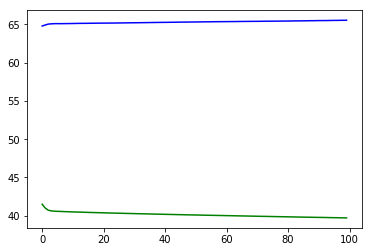

In [22]:
# set timer
start = timeit.default_timer()
# run model
train_loss_ls, val_loss_ls = model(data, x_val, y_val, optimizer, epochs, data_size, batch_size)
# print timer
print('runtime: %.1fs' % (timeit.default_timer() - start))

plt.plot(train_loss_ls, 'g', val_loss_ls, 'b')